# Genre Classification by Actors

Using the IMDB data, construct a feature matrix, and predict a movie's genre by its actors.

In [1]:
%matplotlib inline

In [2]:
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter
from scipy.sparse import lil_matrix

# Necessary import for logistic regression model
from sklearn.linear_model import LogisticRegression

# Necessary for KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# For splitting out training data
from sklearn.model_selection import train_test_split

## Read in Movies with User Ratings

We don't use user ratings here, but we will focus just on these movies to keep our dataset manageable in size.

In [3]:
known_movies = set()

movie_ids = []

with open("../data/user_ratings.json", "r") as in_file:
    for line in in_file:
        
        this_rating = json.loads(line)
        
        known_movies.add(this_rating["title_id"])


In [4]:
movie_id_to_index = {m:i for i,m in enumerate(movie_ids)}

In [5]:
print("Known Movies:", len(known_movies))


Known Movies: 4465


In [6]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_map = {} # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to known movies
        if this_movie["title_id"] not in known_movies:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_map[this_movie["title_id"]] = ({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [7]:
print("Known Actors:", len(known_actors))
print("Known Movies:", len(movie_actor_map))

Known Actors: 5224
Known Movies: 4465


## Generate DataFrame using Sparse Matrics

Convert our Actor data into a DataFrame that we can use for analysis.

In [8]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_map), len(known_actors)), dtype=bool)

movie_list = list(movie_actor_map.items())

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,(movie_id,movie) in enumerate(movie_list):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [9]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m_id for m_id,_ in movie_list],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0073160,nm0066586,nm0000461,nm0002150,nm0463233,nm0000450,nm0000513,nm0383449,nm0641168,nm0424682,...,nm9636805,nm0620847,nm6203022,nm5457688,nm5219130,nm4592524,nm6710968,nm8076737,nm0157717,nm1523626
tt0118589,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0119273,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120202,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0120467,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
tt0120630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9477532,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
tt9495224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
tt9581076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
tt9636500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
print("Movies x Actors dimensionality:", df.shape)

Movies x Actors dimensionality: (4465, 5224)


In [11]:
genres = [movie_actor_map[v]["genres"][0] for v in df.index]

genre2id_index = {g:i for i,g in enumerate(set(genres))}
id2genre_index = {i:g for i,g in enumerate(set(genres))}

Counter(genres)

Counter({'Drama': 969,
         'Action': 990,
         'Comedy': 1241,
         'Crime': 313,
         'Adventure': 333,
         'Biography': 283,
         'Horror': 171,
         'Animation': 26,
         'Mystery': 21,
         'Thriller': 18,
         'Fantasy': 26,
         'Documentary': 59,
         'Family': 1,
         'Sci-Fi': 4,
         'Music': 2,
         'History': 1,
         '\\N': 2,
         'Romance': 4,
         'Western': 1})

## Find Comedies in the Movie Dataset

We'll focus on predicting whether a movie is a comedy or not (i.e., binary classification) as a first step.

In [43]:
is_comedy = ["Comedy" in movie_actor_map[v]["genres"] for v in df.index]

In [44]:
X = df
y = is_comedy

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=31337)

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
# Zip the actors with their model coefficients, so we can inspect actors' roles on the Comedy genre 
actor_weights = list(zip([actor_id_to_name_map[i] for i in X_train.columns], model.coef_[0,:]))

print("Actors with most positive influence on Comedy Genre:")
for tup in sorted(actor_weights, key=lambda t: t[1], reverse=True)[:10]:
    print(tup)
    
print("\nActors with most negative influence on Comedy Genre:")
for tup in sorted(actor_weights, key=lambda t: t[1], reverse=True)[-10:]:
    print(tup)

Actors with most positive influence on Comedy Genre:
('Adam Sandler', 1.964231678122208)
('Paul Rudd', 1.7254561850357466)
('Ben Stiller', 1.644669221189575)
('Owen Wilson', 1.613213574733682)
('Will Ferrell', 1.59412566615105)
('Seann William Scott', 1.5652463586050895)
('Steve Carell', 1.5320389308952633)
('Seth Rogen', 1.5119560417293432)
('Tim Blake Nelson', 1.5044965399637968)
('Martin Lawrence', 1.4835042621365337)

Actors with most negative influence on Comedy Genre:
('Andrew Garfield', -1.1064171718875202)
('Hayden Christensen', -1.1135102182597436)
('Toby Jones', -1.1175137766480376)
('Jared Leto', -1.1425352203066148)
('Daniel Craig', -1.170171273497131)
('Karl Urban', -1.23441765253871)
('Jake Gyllenhaal', -1.2618563001187093)
('Christian Bale', -1.391207060537512)
('Jason Clarke', -1.397242171441073)
('Michael Fassbender', -1.596052939195746)


In [49]:
predicted_genre = model.predict(X_test)

In [50]:
correct_count = 0

for predicted,actual in zip(predicted_genre, y_test):
    if predicted == actual:
        correct_count += 1

print("Correct:", correct_count)
print("Accuracy:", correct_count / predicted_genre.shape[0])

Correct: 665
Accuracy: 0.7446808510638298


In [51]:
model.score(X_test, y_test)

0.7446808510638298

### Zero-Rate Baseline

While the accuracy metric above is useful, providing additional context for this task helps us understand how well the above predictions really are.

To provide such context, we can compare the above model's accuracy to a __baseline__ simple mode.

Here, that baseline mode is called the "zero-rate" or "zero rule" baseline, where we predict the most common class.


In [54]:
baseline_correct = 0

for actual in y_test:
    if actual == 1: # Comedy is the most common genre
        baseline_correct += 1

print("Correct:", baseline_correct)
print("Accuracy:", baseline_correct / len(y_test))

# As you can see, our model's accuracy is way better than this baseline

Correct: 331
Accuracy: 0.3706606942889138


### Predicting Probabilities

Logistic regression yields class assignments in the form of binary labels, as above, but it can also provide estimates on certainty through its `model.predict_proba()` function. This function returns the probabilities for each possible output label (here, just false/not-comedy or true/comedy).

In [56]:
class_probabilities = model.predict_proba(X_test)
class_probabilities

array([[0.57003279, 0.42996721],
       [0.64005542, 0.35994458],
       [0.41241368, 0.58758632],
       ...,
       [0.45021855, 0.54978145],
       [0.62306685, 0.37693315],
       [0.62856484, 0.37143516]])

(array([ 54., 114., 166., 291.,  95.,  69.,  40.,  29.,  24.,  11.]),
 array([0.03641708, 0.13147052, 0.22652395, 0.32157739, 0.41663083,
        0.51168426, 0.6067377 , 0.70179114, 0.79684457, 0.89189801,
        0.98695145]),
 <BarContainer object of 10 artists>)

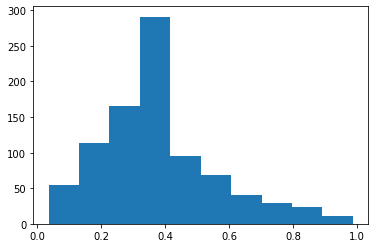

In [59]:
plt.hist(class_probabilities[:,1])

In [76]:
# We can binarize these probabilities easily by putting a threshold
#. on the probability. By default, we may say > 0.5, but
#. we could be more strict and say > 0.9 or more relaxed and say
#. >0.33
prob2binary = class_probabilities[:,1] > 0.5

# After binarization, how many did we get correct?
correct_count = sum(prob2binary == y_test)

print("Correct:", correct_count)

Correct: 665


## Multi-Class Problem

In [21]:
X = df
y = genres

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=31337)

In [23]:
model = LogisticRegression(max_iter=2048)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2048)

In [24]:
predicted_genre = model.predict(X_test)

In [25]:
performance_rows = []
for genre,genre_id in genre2id_index.items():
    
    this_genre_pred = (predicted_genre == id2genre_index[genre_id]) & (np.array(y_test) == id2genre_index[genre_id])
    this_genre_act = np.array(y_test) == id2genre_index[genre_id]
    
    this_genre_count = sum(this_genre_act)
    this_pred_count = sum(this_genre_pred)
    
    score = None
    if this_genre_count > 0:
        score = this_pred_count / this_genre_count
    
    performance_rows.append({
        "genre": genre,
        "count": this_genre_count,
        "precision": score
    })
    
pd.DataFrame(performance_rows).sort_values(by="precision", ascending=False)

,genre,count,precision
8,Comedy,242,0.756198
15,Action,218,0.440367
7,Drama,193,0.310881
4,Adventure,65,0.061538
17,Biography,49,0.061224
16,Crime,59,0.033898
1,Horror,31,0.032258
2,Animation,8,0.000000
3,\N,1,0.000000
6,Romance,1,0.000000


## Apply KNN Classification Model

Above uses the *logistic regression* model, but we can use KNN-classifier here as well.

In [39]:
model = KNeighborsClassifier(n_neighbors=10)

In [40]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [41]:
predicted_genre = model.predict(X_test)

In [42]:
performance_rows = []
for genre,genre_id in genre2id_index.items():
    
    this_genre_pred = (predicted_genre == id2genre_index[genre_id]) & (np.array(y_test) == id2genre_index[genre_id])
    this_genre_act = np.array(y_test) == id2genre_index[genre_id]
    
    this_genre_count = sum(this_genre_act)
    this_pred_count = sum(this_genre_pred)
    
    score = None
    if this_genre_count > 0:
        score = this_pred_count / this_genre_count
    
    performance_rows.append({
        "genre": genre,
        "count": this_genre_count,
        "precision": score
    })
    
pd.DataFrame(performance_rows).sort_values(by="precision", ascending=False)

,genre,count,precision
7,Drama,193,0.746114
8,Comedy,242,0.404959
15,Action,218,0.238532
4,Adventure,65,0.030769
17,Biography,49,0.020408
1,Horror,31,0.000000
2,Animation,8,0.000000
3,\N,1,0.000000
6,Romance,1,0.000000
9,Thriller,3,0.000000
